In [1]:
import math
import torch
import logging
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pickle
import os
import mlflow
import mlflow.pytorch
import re

pattern = r"[^\w'\.,;\?\!]"

with open(".data/wikitext-2/wikitext-2/wiki.train.tokens", "r") as _f:
    _f = _f.read()
    
_f = re.sub(pattern, ' ', _f)

with open(".data/wikitext-2/wikitext-2/wiki.train.tokens", "w") as _w:
    _w = _w.write(_f)


In [ ]:
logging.basicConfig(filename='LMTransformer.log',level=logging.WARNING)

In [2]:
import spacy

from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

In [4]:
params = {"lr":5.8,"epochs":100,
          "embed_dim":240,
          "heads":8,
          "layers":6,
          "seq_len":32,
          "batch_size":64, 
          "name":"picci"}

#mlflow.set_tracking_uri("beefyserv.local:8000")

#mlflow.create_experiment(params["name"])
#mlflow.set_experiment(params["name"])

### Generate square mask

Generates a mask that hides the next item in a sequence to the model, this way the attention block cannot "cheat" and look at the next item.

### Positional Encoding

This is used to embed positional information to the input, this way the model can take into account the position of items as well.

In [5]:
def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to("cuda")
        return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        x = self.dropout(x)
        x = x.to("cuda")
        return x

### Transformer LM

This model will encode the input, apply positional encoding, send the encoded input through the transformer encoder layers and finally through a fully connected layer with an output equal to the number of tokens in the training dataset. In eval mode, when doing only inference, it will save the activations of each batch in a specified path. 

Also, if you are using my fork of pytorch 1.3.1, the transformer object will also have the attributes: **self.attn**, **self.attn_activation**, **self.attn_preactivation** which will allow you to access the attention heads at different stages.

In [6]:
class TransformerModel(nn.Module):
    """
    
    """
    def __init__(self, d_model, nhead=2, num_encoder_layers=1, ntokens=5000):
        super(TransformerModel, self).__init__()
        
        self.num_encoder_layers = num_encoder_layers
        self.nhead = nhead
        self.d_model = d_model
        self.ntokens = ntokens
        self.emb = nn.Embedding(self.ntokens, self.d_model)
        self.posenc = PositionalEncoding(d_model, 0.5)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=1024)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.linear = nn.Linear(self.d_model, self.ntokens)
        self.trans_activation = None
        
    def save_activations(self, epoch=0, batch=0):
        """
        epoch: The running epoch, this information will be added to the files' names.
        batch: The running batch, this information will be added to the files' names
        
        """
        try:
            
            for x in range(len(self.transformer.layers)):
                # save the activations of each transformer encoder layer.
                with open(f"/path/to/harddrive/{params['name']}-attention-{x}-{epoch}-{batch}.p", "wb") as _f:
                    pickle.dump(self.transformer.layers[x].attn_activation.cpu().detach().numpy(), _f)
                           
        except:
            logging.warning("Failed to save activations! No More space left on disk!")
        return 0
        
    
    def forward(self, x, tgt, epoch=0, batch=0):
        x = self.emb(x) #* math.sqrt(self.d_model)
        tgt = self.emb(tgt)
        x = self.posenc(x)
        x = self.transformer(x, generate_square_subsequent_mask(x.shape[0]))
        self.trans_activation = x
        if not self.training:
            self.save_activations(epoch=epoch, batch=batch)
        return self.linear(x)
        
        
        

### This Part is from https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [7]:
import torchtext
from torchtext.data.utils import get_tokenizer

TEXT = torchtext.data.Field(tokenize = "spacy", tokenizer_language="en", 
                            init_token="<sos>", 
                            eos_token="eos", 
                            lower=True)

train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 64
eval_batch_size = 128
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

In [ ]:
bptt = params["seq_len"]

def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [7]:
ntokens = len(TEXT.vocab.stoi)
ntokens

28785

In [8]:
model = TransformerModel(d_model=params["embed_dim"], nhead=params["heads"], num_encoder_layers=params["layers"], ntokens=ntokens)
model = model.to("cuda")

In [9]:
criterion = nn.CrossEntropyLoss()
lr = params["lr"]
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4.0, gamma=0.9)

In [10]:
import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data, data, batch=batch, epoch=epoch)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 128
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    print("DATA SOURCE SIZE!", data_source.size(0))
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data,data, batch=i, epoch=epoch)
            #print(output.shape, output[0])
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [11]:
best_val_loss = float("inf")
epochs = params["epochs"] # The number of epochs
best_model = None

print("STARTING:::::::.........")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

STARTING:::::::.........
| epoch   1 |   128/ 1018 batches | lr 5.80 | ms/batch 372.98 | loss  9.31 | ppl 11068.90
| epoch   1 |   256/ 1018 batches | lr 5.80 | ms/batch 368.68 | loss  7.79 | ppl  2426.01
| epoch   1 |   384/ 1018 batches | lr 5.80 | ms/batch 378.09 | loss  7.45 | ppl  1725.54
| epoch   1 |   512/ 1018 batches | lr 5.80 | ms/batch 382.39 | loss  7.28 | ppl  1450.88
| epoch   1 |   640/ 1018 batches | lr 5.80 | ms/batch 381.97 | loss  7.20 | ppl  1337.75
| epoch   1 |   768/ 1018 batches | lr 5.80 | ms/batch 382.05 | loss  7.16 | ppl  1282.32
| epoch   1 |   896/ 1018 batches | lr 5.80 | ms/batch 381.63 | loss  7.09 | ppl  1202.66
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 408.80s | valid loss  6.93 | valid ppl  1024.75
-----------------------------------------------------------------------------------------
| epoch   2 |   128/ 1018 batches | lr 5.80 | ms/batch 377.57 | los

| epoch  10 |   128/ 1018 batches | lr 4.70 | ms/batch 381.49 | loss  6.90 | ppl   994.53
| epoch  10 |   256/ 1018 batches | lr 4.70 | ms/batch 387.09 | loss  6.85 | ppl   945.89
| epoch  10 |   384/ 1018 batches | lr 4.70 | ms/batch 387.11 | loss  6.86 | ppl   957.23
| epoch  10 |   512/ 1018 batches | lr 4.70 | ms/batch 386.97 | loss  6.84 | ppl   938.07
| epoch  10 |   640/ 1018 batches | lr 4.70 | ms/batch 387.10 | loss  6.84 | ppl   936.34
| epoch  10 |   768/ 1018 batches | lr 4.70 | ms/batch 387.10 | loss  6.86 | ppl   957.75
| epoch  10 |   896/ 1018 batches | lr 4.70 | ms/batch 387.28 | loss  6.87 | ppl   964.20
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 416.43s | valid loss  6.70 | valid ppl   813.57
-----------------------------------------------------------------------------------------
| epoch  11 |   128/ 1018 batches | lr 4.70 | ms/batch 374.56 | loss  6.90 | ppl   995.71
| 

| epoch  19 |   256/ 1018 batches | lr 3.81 | ms/batch 379.04 | loss  5.52 | ppl   248.58
| epoch  19 |   384/ 1018 batches | lr 3.81 | ms/batch 383.93 | loss  5.51 | ppl   247.10
| epoch  19 |   512/ 1018 batches | lr 3.81 | ms/batch 383.65 | loss  5.44 | ppl   230.61
| epoch  19 |   640/ 1018 batches | lr 3.81 | ms/batch 384.04 | loss  5.44 | ppl   229.74
| epoch  19 |   768/ 1018 batches | lr 3.81 | ms/batch 384.10 | loss  5.45 | ppl   232.55
| epoch  19 |   896/ 1018 batches | lr 3.81 | ms/batch 384.15 | loss  5.45 | ppl   233.30
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 412.72s | valid loss  5.47 | valid ppl   236.62
-----------------------------------------------------------------------------------------
| epoch  20 |   128/ 1018 batches | lr 3.81 | ms/batch 379.01 | loss  5.48 | ppl   238.80
| epoch  20 |   256/ 1018 batches | lr 3.81 | ms/batch 384.29 | loss  5.42 | ppl   225.21
| 

| epoch  28 |   384/ 1018 batches | lr 3.08 | ms/batch 383.56 | loss  4.91 | ppl   135.10
| epoch  28 |   512/ 1018 batches | lr 3.08 | ms/batch 383.50 | loss  4.84 | ppl   127.02
| epoch  28 |   640/ 1018 batches | lr 3.08 | ms/batch 383.47 | loss  4.86 | ppl   129.36
| epoch  28 |   768/ 1018 batches | lr 3.08 | ms/batch 383.56 | loss  4.88 | ppl   131.68
| epoch  28 |   896/ 1018 batches | lr 3.08 | ms/batch 383.49 | loss  4.88 | ppl   131.93
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 412.80s | valid loss  5.21 | valid ppl   183.69
-----------------------------------------------------------------------------------------
| epoch  29 |   128/ 1018 batches | lr 2.77 | ms/batch 378.71 | loss  4.91 | ppl   135.76
| epoch  29 |   256/ 1018 batches | lr 2.77 | ms/batch 378.85 | loss  4.86 | ppl   129.08
| epoch  29 |   384/ 1018 batches | lr 2.77 | ms/batch 378.80 | loss  4.85 | ppl   127.77
| 

| epoch  37 |   512/ 1018 batches | lr 2.25 | ms/batch 383.37 | loss  4.51 | ppl    91.00
| epoch  37 |   640/ 1018 batches | lr 2.25 | ms/batch 383.16 | loss  4.53 | ppl    92.98
| epoch  37 |   768/ 1018 batches | lr 2.25 | ms/batch 388.04 | loss  4.56 | ppl    95.34
| epoch  37 |   896/ 1018 batches | lr 2.25 | ms/batch 389.37 | loss  4.55 | ppl    94.66
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 414.10s | valid loss  5.20 | valid ppl   180.76
-----------------------------------------------------------------------------------------
| epoch  38 |   128/ 1018 batches | lr 2.25 | ms/batch 376.57 | loss  4.61 | ppl    99.99
| epoch  38 |   256/ 1018 batches | lr 2.25 | ms/batch 382.27 | loss  4.56 | ppl    95.72
| epoch  38 |   384/ 1018 batches | lr 2.25 | ms/batch 382.96 | loss  4.55 | ppl    94.72
| epoch  38 |   512/ 1018 batches | lr 2.25 | ms/batch 382.93 | loss  4.49 | ppl    89.11
| 

| epoch  46 |   640/ 1018 batches | lr 1.82 | ms/batch 382.86 | loss  4.32 | ppl    75.41
| epoch  46 |   768/ 1018 batches | lr 1.82 | ms/batch 382.79 | loss  4.34 | ppl    77.07
| epoch  46 |   896/ 1018 batches | lr 1.82 | ms/batch 382.90 | loss  4.34 | ppl    76.80
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 411.45s | valid loss  5.21 | valid ppl   183.51
-----------------------------------------------------------------------------------------
| epoch  47 |   128/ 1018 batches | lr 1.82 | ms/batch 378.80 | loss  4.40 | ppl    81.20
| epoch  47 |   256/ 1018 batches | lr 1.82 | ms/batch 378.57 | loss  4.35 | ppl    77.75
| epoch  47 |   384/ 1018 batches | lr 1.82 | ms/batch 382.79 | loss  4.34 | ppl    77.01
| epoch  47 |   512/ 1018 batches | lr 1.82 | ms/batch 382.79 | loss  4.29 | ppl    72.68
| epoch  47 |   640/ 1018 batches | lr 1.82 | ms/batch 382.66 | loss  4.31 | ppl    74.14
| 

| epoch  55 |   768/ 1018 batches | lr 1.47 | ms/batch 382.49 | loss  4.19 | ppl    65.87
| epoch  55 |   896/ 1018 batches | lr 1.47 | ms/batch 382.32 | loss  4.19 | ppl    65.82
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  55 | time: 411.54s | valid loss  5.25 | valid ppl   190.85
-----------------------------------------------------------------------------------------
| epoch  56 |   128/ 1018 batches | lr 1.47 | ms/batch 380.26 | loss  4.24 | ppl    69.52
| epoch  56 |   256/ 1018 batches | lr 1.47 | ms/batch 382.54 | loss  4.20 | ppl    66.60
| epoch  56 |   384/ 1018 batches | lr 1.47 | ms/batch 382.40 | loss  4.19 | ppl    66.03
| epoch  56 |   512/ 1018 batches | lr 1.47 | ms/batch 382.47 | loss  4.13 | ppl    62.42
| epoch  56 |   640/ 1018 batches | lr 1.47 | ms/batch 382.54 | loss  4.15 | ppl    63.75
| epoch  56 |   768/ 1018 batches | lr 1.47 | ms/batch 383.80 | loss  4.18 | ppl    65.10
| 

| epoch  64 |   896/ 1018 batches | lr 1.19 | ms/batch 382.70 | loss  4.07 | ppl    58.49
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  64 | time: 411.43s | valid loss  5.30 | valid ppl   199.71
-----------------------------------------------------------------------------------------
| epoch  65 |   128/ 1018 batches | lr 1.07 | ms/batch 376.84 | loss  4.11 | ppl    61.21
| epoch  65 |   256/ 1018 batches | lr 1.07 | ms/batch 377.86 | loss  4.08 | ppl    59.01
| epoch  65 |   384/ 1018 batches | lr 1.07 | ms/batch 377.96 | loss  4.06 | ppl    58.22
| epoch  65 |   512/ 1018 batches | lr 1.07 | ms/batch 377.96 | loss  4.01 | ppl    55.27
| epoch  65 |   640/ 1018 batches | lr 1.07 | ms/batch 377.96 | loss  4.03 | ppl    56.10
| epoch  65 |   768/ 1018 batches | lr 1.07 | ms/batch 378.05 | loss  4.05 | ppl    57.36
| epoch  65 |   896/ 1018 batches | lr 1.07 | ms/batch 381.13 | loss  4.05 | ppl    57.27
DA

DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  73 | time: 410.18s | valid loss  5.33 | valid ppl   206.45
-----------------------------------------------------------------------------------------
| epoch  74 |   128/ 1018 batches | lr 0.87 | ms/batch 378.83 | loss  4.03 | ppl    56.18
| epoch  74 |   256/ 1018 batches | lr 0.87 | ms/batch 378.06 | loss  3.99 | ppl    53.83
| epoch  74 |   384/ 1018 batches | lr 0.87 | ms/batch 377.90 | loss  3.98 | ppl    53.43
| epoch  74 |   512/ 1018 batches | lr 0.87 | ms/batch 377.92 | loss  3.93 | ppl    50.95
| epoch  74 |   640/ 1018 batches | lr 0.87 | ms/batch 377.85 | loss  3.95 | ppl    51.76
| epoch  74 |   768/ 1018 batches | lr 0.87 | ms/batch 380.40 | loss  3.97 | ppl    53.03
| epoch  74 |   896/ 1018 batches | lr 0.87 | ms/batch 382.63 | loss  3.96 | ppl    52.65
DATA SOURCE SIZE! 1704
---------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  82 | time: 412.66s | valid loss  5.37 | valid ppl   213.87
-----------------------------------------------------------------------------------------
| epoch  83 |   128/ 1018 batches | lr 0.71 | ms/batch 377.63 | loss  3.96 | ppl    52.50
| epoch  83 |   256/ 1018 batches | lr 0.71 | ms/batch 377.67 | loss  3.92 | ppl    50.48
| epoch  83 |   384/ 1018 batches | lr 0.71 | ms/batch 381.70 | loss  3.92 | ppl    50.37
| epoch  83 |   512/ 1018 batches | lr 0.71 | ms/batch 382.33 | loss  3.86 | ppl    47.55
| epoch  83 |   640/ 1018 batches | lr 0.71 | ms/batch 382.08 | loss  3.88 | ppl    48.53
| epoch  83 |   768/ 1018 batches | lr 0.71 | ms/batch 382.16 | loss  3.90 | ppl    49.52
| epoch  83 |   896/ 1018 batches | lr 0.71 | ms/batch 382.24 | loss  3.90 | ppl    49.37
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| 

| epoch  92 |   128/ 1018 batches | lr 0.57 | ms/batch 381.82 | loss  3.91 | ppl    50.01
| epoch  92 |   256/ 1018 batches | lr 0.57 | ms/batch 388.48 | loss  3.88 | ppl    48.19
| epoch  92 |   384/ 1018 batches | lr 0.57 | ms/batch 388.48 | loss  3.87 | ppl    47.88
| epoch  92 |   512/ 1018 batches | lr 0.57 | ms/batch 388.64 | loss  3.82 | ppl    45.45
| epoch  92 |   640/ 1018 batches | lr 0.57 | ms/batch 388.46 | loss  3.83 | ppl    46.25
| epoch  92 |   768/ 1018 batches | lr 0.57 | ms/batch 388.40 | loss  3.86 | ppl    47.38
| epoch  92 |   896/ 1018 batches | lr 0.57 | ms/batch 388.29 | loss  3.85 | ppl    47.02
DATA SOURCE SIZE! 1704
-----------------------------------------------------------------------------------------
| end of epoch  92 | time: 418.39s | valid loss  5.40 | valid ppl   221.49
-----------------------------------------------------------------------------------------
| epoch  93 |   128/ 1018 batches | lr 0.51 | ms/batch 379.63 | loss  3.91 | ppl    50.08
| 

In [13]:
frase = "the president of the united".split()


def generate_sent(frase, model, TEXT, words=5):
    """
    This function gets a list of a split string and 
    returns a new string with the next N number of words 
    predicted by the model
    """
    
    for i in range(words):
        frasevec = TEXT.numericalize([frase]).to("cuda")
        model.eval()
        var = model(frasevec, frasevec).squeeze(1)
        most = torch.argmax(var[-1])
        frase.append(TEXT.vocab.itos[most.cpu().detach().numpy()])
    
    return " ".join(frase)


f = generate_sent(frase, model, TEXT)
print(f)
len(f)

6
7
8
9
10
the president of the united states . <eos> <eos> =


50

### Performing evaluation on test set

In [ ]:
test_loss = evaluate(model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

### In case you want to have a look at the attention heads...

In [43]:
print(model.transformer.layers[0].attn.shape)
print(model.transformer.layers[0].attn_preactivation.shape)
print(model.transformer.layers[0].attn_activation.shape)

torch.Size([8, 9, 9])
torch.Size([9, 1, 120])
torch.Size([9, 1, 120])
torch.Size([120, 1024])


## Visualizing attention
This next cell shows the attention heads activations from the previous sentence given to **generate_sent()**.
Each head from each transformer encoder layer will be displayed.

6
torch.Size([8, 9, 9])
torch.Size([8, 9, 9])
torch.Size([8, 9, 9])
torch.Size([8, 9, 9])
torch.Size([8, 9, 9])
torch.Size([8, 9, 9])


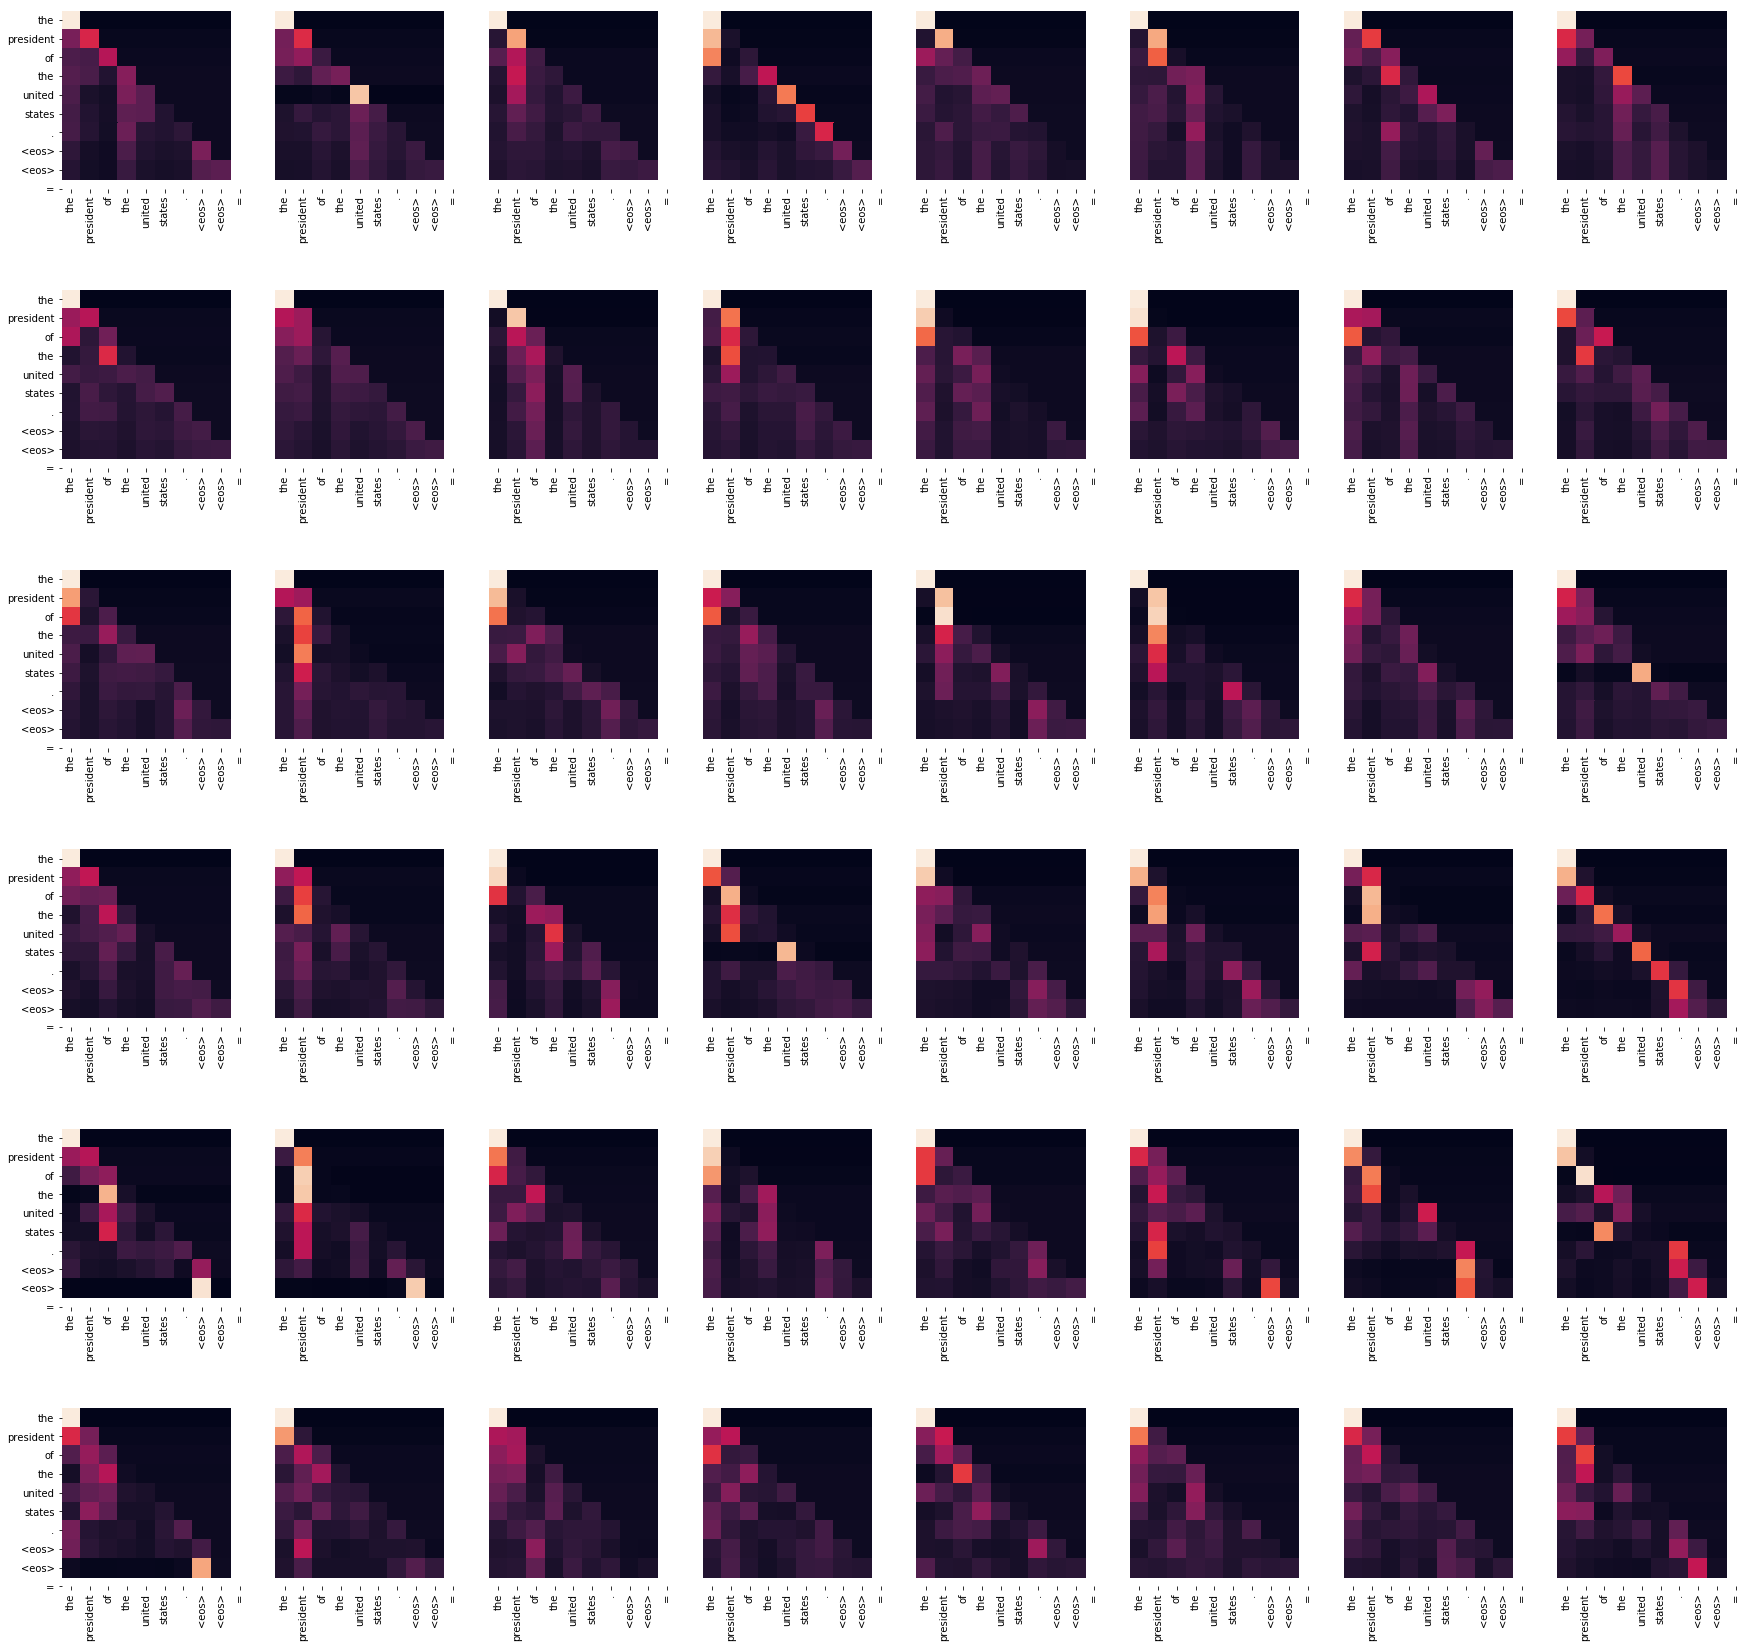

In [15]:
sent = f.split()

import seaborn
import matplotlib.pyplot as plt
import torch.nn.functional as F

fig, axs = plt.subplots(params["layers"],params["heads"], figsize=(30, 30))

for j in range(params["layers"]):
    
    print(f"Plotting layer {j+1}...")
    x = model.transformer.layers[j].attn.data
    x = F.softmax(x, dim = -1)
    
    for i in range(x.shape[0]):
        
        if i != 0:
            seaborn.heatmap(x[i,:,:].cpu().numpy(), square=True, cbar=False, 
                             cbar_kws={"shrink": .00001, "ticks":None, },
                             yticklabels=[""]*len(sent), xticklabels=sent, ax=axs[j,i])
            axs[j,i].tick_params(axis='y', which='both', length=0)
            
        else:
            seaborn.heatmap(x[i,:,:].cpu().numpy(), square=True, cbar=False, 
                             cbar_kws={"shrink": .00001, "ticks":None, },
                             yticklabels=sent, xticklabels=sent, ax=axs[j,i])


In [ ]:
x = model.transformer.layers[1].attn.data
print(x.shape)
import seaborn
import matplotlib.pyplot as plt
import torch.nn.functional as F
x = F.softmax(x)
fig, axs = plt.subplots(1,4, figsize=(20, 10))
for i in range(x.shape[0]):
    seaborn.heatmap(x[i,:,:].cpu().numpy(), square=True,ax=axs[i])


In [12]:
#torch.save(model, "transformer1.pth")
torch.save(model.state_dict(), f'transformer-{params["name"]}-6encod-8heads-240dim-100epoch-state.pth')

In [9]:
model.load_state_dict(torch.load("transformer-3encod-8heads-120dim-100epoch-state.pth"))

<All keys matched successfully>

### Here starts the savagery in order to perform SVCCA on all the activations from training.

In [63]:
files = [x for x in os.listdir("") if x.endswith(".p")]
print(len(files))
      
diz = {}

for x in files:
    #if (x.split("-")[1] == "20" or x.split("-")[1] == "2") and x.split("-")[0] == "attention0":
    if "attention" in x.split("-")[0] and int(x.split("-")[1]) < 51:
        try:
            diz[x] = x
#            diz[x] = pickle.load(open(f"/activations/mask/{x}", "rb"))
        except:
            continue


463421


In [64]:
kys = []
for x in diz.keys():
    #x = "-".join([x.split("-")[0][:-1],x.split("-")[1]])
    x = x.split("-")[1]
    if x not in kys:
        kys.append(x)
print(kys[:])
#diz['output-19-2144.p'].shape

['5', '1', '12', '20', '23', '39', '49', '26', '4', '32', '44', '35', '31', '10', '50', '9', '2', '47', '16', '38', '25', '13', '41', '29', '30', '6', '14', '19', '36', '43', '40', '24', '8', '48', '17', '33', '22', '15', '42', '11', '37', '27', '45', '28', '34', '7', '3', '21', '46', '18', '0']


In [5]:
import numpy as np

def get_svcca(n):
    epoch1 = [diz[x] for x in diz.keys() if x.split("-")[1] == f"{n}" and diz[x].shape[0] == 32 and diz[x].shape[1] == 10]
    new = np.concatenate(epoch1, axis=0)
    print(new.shape)
    if new.shape[0] != 21792:
        return None
    newnew = new.reshape((new.shape[0], new.shape[1]*new.shape[2]))
    print(newnew.shape)
#    epoch2 = [diz[x] for x in diz.keys() if x.split("-")[1] == f"20" and diz[x].shape[1] == 32]
#    new = np.concatenate(epoch2, axis=0)
#    newnew2 = new.reshape((32*6810, 100))
    return newnew

In [ ]:
limit = 29
forsvcca = [0] * (limit+1)
for x in range(0,limit):
    forsvcca[x] = get_svcca(x+1)
    print(forsvcca[x], x)
forsvcca[-1] = get_svcca(30)


In [ ]:
import cca_core
import numpy as np
import matplotlib.pyplot as plt

# Plot function from google's svcca tutorial
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

means = [0] * (len(forsvcca)+1)
    
for i in range(len(forsvcca)):
    if forsvcca[i] is not None:
        print(forsvcca[i].shape, forsvcca[-1].shape)
        results = cca_core.get_cca_similarity(np.transpose(forsvcca[i], (1,0)), np.transpose(forsvcca[-1], (1,0)), epsilon=1e-6) #include epsilon=1e-N when the activation vectors may contain very small values
        print(results["mean"])
#_plot_helper(results["cca_coef1"], "Nodes", "CCA Coef value")
        print("Mean CCA similarity", np.mean(results["cca_coef1"]))
        means[i] = np.mean(results["cca_coef1"])
    else:
        print("NONE!",forsvcca[i])
    
print(means)

[0.19339456049915277, 0.19631033820487115, 0.19775566251771273, 0.19750327315504726, 0.20124257128979908, 0.20008921605210245, 0.20011616167680735, 0.20072537906333243, 0.2012917817325917, 0.2018131448264943, 0.2024614080658314, 0.2023010190287431, 0.20287649597319837, 0.20282935386274123, 0.2029539125192972, 0.2034755004662282, 0.203708395836388, 0.9897441363803128]


18

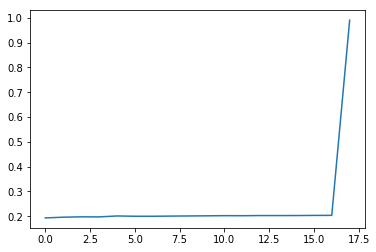

In [25]:
means = [x for x in means if x != 0]
print(means)
plt.plot(range(len(means)), means)
len(means)